# Visualize your Lookout for Metrics on QuickSight
## Introduction
The notebook generates all the necessary resources to bring your inference results and live data from Amazon Lookout for Metrics (L4M) to Amazon Quickight to allow the building of visualizations. The services used in this notebook are:

-[Amazon Lookout for Metrics](https://aws.amazon.com/lookout-for-metrics/)

-[Amazon QuickSight](https://aws.amazon.com/quicksight/)

-[AWS Glue](https://aws.amazon.com/glue)

-[Amazon Athena](https://aws.amazon.com/athena)

-[Amazon S3](https://aws.amazon.com/s3/)

-[Amazon Lambda](https://aws.amazon.com/lambda)

Amazon Lookout for Metrics (L4M) is there to inference your live data, detect anomalies and send alerts to the Lambda function. The Lambda function is called by L4M and process the anomaly to after store the results in S3. AWS Glue takes care of building the metadata of your data (Lambda results and live data) by using a crawler to understand your data and save the results as metadata tables in a Glue database. Amazon Athena is the bridge between Amazon QuickSight and Amazon S3 that allows QuickSight to query S3. Finally, Amazon QuickSight will allow the visualization of your data by building dashboards.


Notes: 
- Once you reach the end of this notebook, the data will be available in QuickSight for you to  build your own dashboards.

- This notebook follows and is build on the top of the previous notebooks from L4M in this [github repository](https://docs.aws.amazon.com/quicksight/latest/user/signing-up.html). If you want to use this for your own use case, the notebook is automated up to the QuickSight chapter. You will have to adapt some of the cells starting from Quicksight. When you reach the part to build the analysis, you <font color='red'>have to</font> create it from the QuickSight console. Refer to the "Analysis creation without enterprise account" part of this notebook (even if you have an enterprise account), or use the QuickSight [documentation](https://docs.aws.amazon.com/quicksight/latest/user/creating-an-analysis.html). In the conclusion part explaining the metrics, some of the metrics will be different according to your use case.

## Prerequisites
To go through this notebook, you need to make sure to update the customer inputs section below according to your account/data.
You need to be connected to your AWS account and have all the necessary permissions to run the following API calls. 
This notebook considers that you already have a running L4M detector and will not go through the process. If you do not have a running L4M detector, I invite you to follow the [L4M AWS sample](https://github.com/aws-samples/amazon-lookout-for-metrics-samples) to create one . 
You need to have a QuickSight account. If you do not have one, go in the AWS console, go to QuickSight, and [create an account](https://docs.aws.amazon.com/quicksight/latest/user/signing-up.html). 

Note: 
You need an Amazon QuickSight enterprise account to run from this notebook the API call to generate the analysis part. If you do not have an enterprise account and do not wish to have one, once you have created the dataset in this notebook, you can go to the console of QuickSight and generate in an easy 2 steps way an analysis of the dataset generated via this notebook. Instructions on how to do it are at the end of this notebook.

## Customer inputs

In [ ]:

bucket_arn = '' #Add the bucket name and Arn from where is your live data located
bucket_name= ''
L4M_AnomalyDetectorArn=''
inference_data_input_path_s3=''#Add the S3 URI from where is located your S3 data: the data that L4M uses for inference (input) 

#Update the user name according to yours (QuickSight username). You can find it in the QuickSight console on the top right. 
#Update the region_user_Quicksight according to where you have created the QuickSight account that you will be using.
#Update the region_L4M according to where is your L4M detector deployed.
user_name = ''
region_user_Quicksight = ''
region_L4M = ''


## Notebook start
### Importation of libraries and clients initialization

In [ ]:
!pip install patool
import patoolib
import boto3
import os
import json
import utility
import time
from zipfile import ZipFile
from IPython.display import clear_output

response = boto3.client('sts').get_caller_identity()
AwsAccountId=response['Account']
clientGlue = boto3.client('glue', region_name=region_L4M)
clientQuicksight = boto3.client('quicksight', region_name=region_user_Quicksight)
clientLambda = boto3.client('lambda',region_name=region_L4M)
clientL4M = boto3.client('lookoutmetrics',region_name=region_L4M)
clientS3 = boto3.client('s3', region_name=region_L4M)
response = clientQuicksight.describe_user(
    UserName=user_name,
    AwsAccountId=AwsAccountId,
    Namespace='default'
)
user_ARN = response['User']['Arn']
clientQuicksight = boto3.client('quicksight', region_name=region_L4M)
inference_data_output_Lambda_path_s3='s3://'+bucket_name+'/anomalyResults/'

### Roles generator

In [ ]:
role_name_crawler_and_Policy_ARN = utility.crawlerRoleCreation(bucket_arn)
role_name_lambda_and_ARN_and_Policy_ARN = utility.lambda_role(bucket_arn,L4M_AnomalyDetectorArn)

## Lambda Function
### Adapt Lambda to your use case

<font color='red'>WARNING</font> Before running the cell below, you need to update the bucket and the Dataset_ARN values. You can find them at the end of the code/cell. Once updated, run the cell and it will generate a python file containing the code. This is the Lambda function that will be afterwards uploaded to AWS Lambda.

In [ ]:
%%writefile lambda_function.py
import time
import os
import io
import json
import shutil
import zipfile
import pathlib
import pandas as pd
import boto3
import datetime
import botocore
from dateutil.parser import parse
s3 = boto3.client('s3')
lookoutmetrics_client = boto3.client( "lookoutmetrics")

def lambda_handler(event, context):
    
    #Function to format the date given by the event
    def datetime_from_string(s):
        try:
            dt = datetime.datetime.fromisoformat(s.split("[")[0])
        except ValueError:
            dt = datetime.datetime.strptime(s.split("[")[0], "%Y-%m-%dT%H:%MZ")
        return dt
    #Function to update the metricValue_AnomalyScore csv in the case that one already exists
    def update_Anomaly_CSV(event,key,bucket,obj,response):
        print('object exist')
        #Reading the existing file
        original_df = pd.read_csv(obj.get("Body"), index_col=False)
        file2 = original_df.to_dict('list')

        #getting the needed data
        metricList = response['MetricList']
        dimensionList = response['DimensionList']
        metricName = event['impactedMetric']['metricName']
 
        #Column names generator
        data2={}
        data2['key']=[]
        data2['Timestamp'] =[]
        for i in dimensionList:
            data2[i]=[]
        #    data2[i]=[]
        for i in metricList:
            data2[i['MetricName']+'AnomalyMetricValue']=[]
            data2[i['MetricName']+'GroupScore']=[]
    
        #Data collection from the event for the CSV
        for i in event['impactedMetric']['relevantTimeSeries']:
            for a in i['dimensions']:
                data2[a['dimensionName']].append(a['dimensionValue'])
            data2[metricName+'AnomalyMetricValue'].append(i['metricValue'])
            data2[metricName+'GroupScore'].append(event['anomalyScore'])
            data2['Timestamp'].append(start_time)
            
        nRow=len(data2['Timestamp'])
        nDimension = len(dimensionList)
        
        #key generator
        i=0
        while i<nRow:
            value=''
            for a in dimensionList:
                value+=str(data2[a][i])
            value= str(data2['Timestamp'][i])+value
            data2['key'].append(value)
            i=i+1
        c=0
        #Checking if the data is  already in the original file and ammend the empty spaces and add the data  
        for n in data2['key']:
            
            if n in file2['key']:
                where=file2['key'].index(n)
                file2[metricName+'AnomalyMetricValue'][where] = data2[metricName+'AnomalyMetricValue'][c]
                file2[metricName+'GroupScore'][where] =data2[metricName+'GroupScore'][c]
            else:
                file2['key'].append(data2['key'][c])
                for i in dimensionList:
                    file2[i].append(data2[i][c])
                
                file2[metricName+'AnomalyMetricValue'].append(data2[metricName+'AnomalyMetricValue'][c])
                file2[metricName+'GroupScore'].append(data2[metricName+'GroupScore'][c])
                file2['Timestamp'].append(dateTime)
            c+=1
            
        df = pd.DataFrame.from_dict(data=file2, orient='index')
        df2 = df.transpose()
        with io.StringIO() as filename:
            df2.to_csv(filename, index=False, encoding='utf-8')
            response = s3.put_object(
                Bucket=bucket, Key=key, Body=filename.getvalue()
            )
        print('updated Anomaly csv saved')
    #If the metricValue_AnomalyScore file does not exist it will create one
    def generate_Anomaly_CSV(event,key,bucket,response):
        #getting the needed data
        metricList = response['MetricList']
        dimensionList = response['DimensionList']
        metricName = event['impactedMetric']['metricName']
        pd.options.mode.use_inf_as_na = True
        
        #Column names generator
        data2={}
        data2['key']=[]
        data2['Timestamp'] =[]
        for i in dimensionList:
            data2[i]=[]
            data2[i]=[]
        for i in metricList:
            data2[i['MetricName']+'AnomalyMetricValue']=[]
            data2[i['MetricName']+'GroupScore']=[]
    
        #Data collection for the CSV
        for i in event['impactedMetric']['relevantTimeSeries']:
            for a in i['dimensions']:
                data2[a['dimensionName']].append(a['dimensionValue'])
            data2[metricName+'AnomalyMetricValue'].append(i['metricValue'])
            data2[metricName+'GroupScore'].append(event['anomalyScore'])
            data2['Timestamp'].append(start_time)
        nRow=len(data2['Timestamp'])
        #key generator
        i=0
        while i<nRow:
            value=''
            for a in dimensionList:
                value+=str(data2[a][i])
            value= str(data2['Timestamp'][i])+value
            data2['key'].append(value)
            i+=1

        df = pd.DataFrame.from_dict(data=data2, orient='index')
        df2 = df.transpose()

        with io.StringIO() as filename:
            df2.to_csv(filename, index=False, encoding='utf-8')
            response = s3.put_object(
                Bucket=bucket, Key=key, Body=filename.getvalue()
            )
        print('Anomaly csv saved in', key)
    #Checks if the metricValue_AnomalyScore file already exists
    def Anomaly_CSV_Check(event,key,bucket,response):
        try:
            obj = s3.get_object(Bucket=bucket,Key=key) 
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code']=='404' or e.response['Error']['Code']=='NoSuchKey':
                print('the Anomaly csv file does not exist and we will generate the very first file now')
                generate_Anomaly_CSV(event,key,bucket,response)
            else:
                print('something else happened')
                print('error is', e.response)
                raise
        else:
            update_Anomaly_CSV(event,key,bucket,obj,response)
    #Updates the dimensionContributions csv file if it exists
    def update_Dimension_CSV(event,key,obj,bucket):
        print('object exist')
        original_df = pd.read_csv(obj.get("Body"), index_col=False)
        file = original_df.to_dict('list')
        #Column Titles generation
        data = {}
        data ['Timestamp'] =[]
        data['metricName'] =[]
        data['dimensionName'] =[]
        data['dimensionValue'] =[]
        data['valueContribution'] =[]
        
        #Data collection for the CSV
        for i in event['impactedMetric']['dimensionContribution']:
            for a in i['dimensionValueContributions']:
                data['Timestamp'].append(start_time)
                data['dimensionName'].append(i['dimensionName'])
                data['dimensionValue'].append(a['dimensionValue'])
                data['valueContribution'].append(a['valueContribution'])
                data['metricName'].append(event['impactedMetric']['metricName'])
          
        df=pd.DataFrame(data=data)
        df2 = pd.DataFrame(data=file)
        result = pd.concat([df2, df])

        with io.StringIO() as filename:
            result.to_csv(filename, index=False, encoding='utf-8')
            response = s3.put_object(
                Bucket=bucket, Key=key, Body=filename.getvalue()
            )
        print('updated Dimension csv saved')
    
    #Generates the dimensionContributions csv file     
    def generate_Dimension_CSV(event,key,bucket):
        #Column Titles generator
        data = {}
        data ['Timestamp'] =[]
        data['metricName'] =[]
        data['dimensionName'] =[]
        data['dimensionValue'] =[]
        data['valueContribution'] =[]
        
        #Data collection for the CSV
        for i in event['impactedMetric']['dimensionContribution']:
            for a in i['dimensionValueContributions']:
                data['Timestamp'].append(start_time)
                data['dimensionName'].append(i['dimensionName'])
                data['dimensionValue'].append(a['dimensionValue'])
                data['valueContribution'].append(a['valueContribution'])
                data['metricName'].append(event['impactedMetric']['metricName'])
          
        df=pd.DataFrame(data=data)
        print('the dimension first csv file is', )
        #CSV generation and upload to S3
        with io.StringIO() as filename:
            df.to_csv(filename, index=False)
            response = s3.put_object(
                Bucket=bucket, Key=key, Body=filename.getvalue()
            )
        print('the Dimension CSV has been saved in', key)
    #Checks if the dimensionContributions csv file already exists
    def Dimension_CSV_Check(event,key,bucket):
        try:
           obj = s3.get_object(Bucket=bucket,Key=key) 
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code']=='404' or e.response['Error']['Code']=='NoSuchKey':
                print('the Dimension csv file does not exist and we will generate the very first file now')
                generate_Dimension_CSV(event,key,bucket)
            else:
                print('something else happened')
                print('error is', e.response)
                raise
        else:
            update_Dimension_CSV(event,key,obj,bucket)
    
    start_time = datetime_from_string(event["timestamp"] )
    dateTime = str(start_time)
    splitdate = dateTime.split()
    
    #Initial parameters. Here you write the bucket and the ARN from the dataset of the detector (do not change the key1 and key2)
    #Write the bucket where you want the results to be located. THE BUCKET HAS TO ALREADY EXIST
    bucket = '-your bucket-'
    DataSet_ARN = '-ARN from the dataset of your detector-'
    
    key1 = 'anomalyResults/metricValue_AnomalyScore/'+splitdate[0]+'_'+splitdate[1]+'_metricValue_AnomalyScore.csv'
    key2 = 'anomalyResults/dimensionContributions/'+splitdate[0]+'_'+splitdate[1]+'_dimensionContributions.csv'
    
    response = lookoutmetrics_client.describe_metric_set(MetricSetArn=DataSet_ARN)
    Anomaly_CSV_Check(event,key1,bucket,response)
    Dimension_CSV_Check(event,key2,bucket)

### Lambda zip file upload into S3

In [ ]:
#We here compress the file to zip and after upload it to S3 so the Lambda function can after use it
zipObj = ZipFile('Lambda_for_L4E_alerts.zip', 'w')
zipObj.write('lambda_function.py')
zipObj.close()
clientS3 = boto3.client('s3', region_name=region_L4M)
s3 = boto3.resource('s3')
s3.meta.client.upload_file('Lambda_for_L4E_alerts.zip', bucket_name, 'lambdaFunction/Lambda_for_L4E_alerts.zip')

### Lambda function creation

The deployment of the Lambda below is in us-west-2 region. If you would like to deploy it in another region, you have to change the arn of the layer (it imports the panda library). You can find the layer arn according to your region [here](https://github.com/keithrozario/Klayers/tree/master/deployments/python3.8/arns). Select the region, look for the latest panda version, copy its arn and replace the arn layer below with the one you just copied.

In [ ]:
response_lambda = clientLambda.create_function(
    FunctionName='L4M_FROM_NOTEBOOK',
    Runtime='python3.8',
    Handler='lambda_function.lambda_handler',
    Role=role_name_lambda_and_ARN_and_Policy_ARN[1],
    Code={
        'S3Bucket': bucket_name,
        'S3Key': 'lambdaFunction/Lambda_for_L4E_alerts.zip',
    },
    Description='Function reacting to L4M and created by the notebook',
    Timeout=15,
    MemorySize=200,
    Publish=False,
    PackageType='Zip',
    Layers=[
        'arn:aws:lambda:us-west-2:770693421928:layer:Klayers-python38-pandas:38'
    ]
)


### Configuring a Lambda function as an alert triggered by L4M

In [ ]:
#L4M role creation to send alerts and activate Lambda
role_L4M_name_and_ARN_and_Policy_ARN = utility.L4M_role(response_lambda['FunctionArn'])
time.sleep(15)
#Alert creation for L4M
response_alertL4M = clientL4M.create_alert(
    AlertName='LambdaFromNotebook',
    AlertSensitivityThreshold=50,
    AlertDescription='alert generated by notebook',
    AnomalyDetectorArn=L4M_AnomalyDetectorArn,
    Action={
        'LambdaConfiguration': {
            'RoleArn': role_L4M_name_and_ARN_and_Policy_ARN[1],
            'LambdaArn': response_lambda['FunctionArn']
        }
    },
)

## Amazon Glue
### Database creation
The following API will create a database in Glue in the region you specified previously. The database allows to store the metadata of the tables built by the crawler below. 

In [ ]:
#Database creation
response_glueDatabase = clientGlue.create_database(
    DatabaseInput={
        'Name': 'L4M_from_coding',
        'Description': 'Database to visualize the L4M results on Quicksight'
    }
)

### Crawler creation and start
The following API call will create the crawler and the one in the second cell will run the crawler. How long the crawler will take to go through your data will depend on the size and complexity of the data. 

In [ ]:
crawler_name = 'L4M_coding'
response_crawler = clientGlue.create_crawler(
    Name=crawler_name,
    Role= role_name_crawler_and_Policy_ARN[0],
    DatabaseName='L4M_from_coding',
    Description= 'Crawler created by coding to visualize L4M results',
    Targets={
        'S3Targets':[
            {
                'Path': inference_data_input_path_s3
            },
            {
                'Path': inference_data_output_Lambda_path_s3
            }
        ]
    }
)

Before continuing and running the crawler in the cell below, you need to wait that an anomaly has been detected by your L4M detector. When an anomaly is detected, L4M triggers the Lambda function and it generates the csv files containing the results of the anomaly. Once you have these csv files which are located according to the *inference_data_output_Lambda_path_s3* variable, you can continue with this notebook and run the cell below. 

In [ ]:
clientGlue.start_crawler(Name=crawler_name)
finish=False
while finish==False:
    
    response = clientGlue.get_crawler(
        Name=crawler_name,        
    )
    if response['Crawler']['State']=='STOPPING':
        time.sleep(20)
        print('Crawler has finished')
        finish=True
    else:
        print('Crawler is running')
        time.sleep(10)

## Amazon QuickSight
The Amazon QuickSight is into divided in 3 parts: the data source creation, the dataset creation and the analysis creation. As a reminder, starting from the analysis creation, you need an Amazon QuickSight enterprise account to generate the analysis via the notebook. If you do not have one, at the end of this notebook, there are the steps on how to create an analysis via the the Amazon QuickSight console.

In [ ]:
response_datasource = clientQuicksight.create_data_source(
    AwsAccountId=AwsAccountId,
    DataSourceId='L4M_Visualization_datasource',
    Name='L4M_Visualization',
    Type='ATHENA',
    Permissions=[
        {
            'Principal': user_ARN,
            'Actions': [               
                'quicksight:DescribeDataSource',
                'quicksight:DescribeDataSourcePermissions',
                'quicksight:UpdateDataSource',
                'quicksight:UpdateDataSourcePermissions',
                'quicksight:DeleteDataSource',
                'quicksight:PassDataSource',
            ]
        },
    ],
    
)

In [ ]:
#Values collection for QuickSight Datasets
response_glue_tables = clientGlue.get_tables(
    DatabaseName='L4M_from_coding'
)
s= response_glue_tables['TableList']
table_dimensioncontributions = next((item for item in s if item['Name'] == 'dimensioncontributions'), None)
table_metricvalueAnomalyscore = next((item for item in s if item['Name'] == 'metricvalue_anomalyscore'), None)
table_liveData = next((item for item in s if item['Name'] == 'live'), None)

#Formating the data to fit the dataset for QuickSight
for item in table_dimensioncontributions['StorageDescriptor']['Columns']:
    item['Type'] =  item['Type'].upper()
    if item['Type']=='DOUBLE' or item['Type']=='BIGINT':
        item['Type']='DECIMAL'
        
for item in table_metricvalueAnomalyscore['StorageDescriptor']['Columns']:
    item['Type'] =  item['Type'].upper()
    if item['Type']=='DOUBLE' or item['Type']=='BIGINT':
        item['Type']='DECIMAL'
        
for item in table_liveData['StorageDescriptor']['Columns']:
    item['Type'] =  item['Type'].upper()
    if item['Type']=='DOUBLE' or item['Type']=='BIGINT':
        item['Type']='DECIMAL'

### Dataset creation
Here is where you start generating the structure of your future tables. We will generate two datasets by using the API call [create_data_set()](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/quicksight.html#QuickSight.Client.create_data_set) below twice. In the physical table map parameter we join two tables generated by the crawler. In the first cell below we join the tables *dimensioncontributions* and *metricvalueAnomalyscore*. In the second cell we join the tables *liveData* and *metricvalueAnomalyscore*. The variable *colummns_to_be_shown* allows to choose what metrics you would like to see in your analysis.

In [ ]:
colummns_to_be_shown = ['timestamp','dimensionname','dimensionvalue','marketplace','metricname',
                        'valuecontribution','platform','revenueanomalymetricvalue','revenuegroupscore',
                        'viewsanomalymetricvalue','viewsgroupscore']


response_dataset_dimension = clientQuicksight.create_data_set(
    AwsAccountId= AwsAccountId,
    DataSetId='L4M_Visualization_dataset_with_dimensionContribution',
    Name='L4M_Visualization_dataset_with_dimensionContribution',
    PhysicalTableMap={
        'dimensioncontributions': {
            'RelationalTable': {
                'DataSourceArn': response_datasource['Arn'],
                'Catalog': 'AwsDataCatalog',
                'Schema': 'l4m_from_coding',
                'Name': 'dimensioncontributions',
                'InputColumns': table_dimensioncontributions['StorageDescriptor']['Columns']                              
            }          
        },
        'metricvalueAnomalyscore': {
            'RelationalTable': {
                'DataSourceArn': response_datasource['Arn'],
                'Catalog': 'AwsDataCatalog',
                'Schema': 'l4m_from_coding',
                'Name': 'metricvalue_anomalyscore',
                'InputColumns': table_metricvalueAnomalyscore['StorageDescriptor']['Columns']                
            }          
        },
    },
    
    LogicalTableMap={
        'dimensioncontributions': {
            'Alias': 'alias dimensioncontributions',
            'Source':{
                'PhysicalTableId': 'dimensioncontributions'
            },
            'DataTransforms': [
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'timestamp',
                        'NewColumnName': 'timestampoutput'
                    }
                }                         
            ],
            
        },
        'metricvalueAnomalyscore':{
            'Alias': 'alias metricvalueAnomalyscore',
            'Source':{
                'PhysicalTableId': 'metricvalueAnomalyscore'
            },
            'DataTransforms': [
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'timestamp',
                        'NewColumnName': 'timestamp2'
                    }
                }                         
            ],
        },
      
        'joinWithRight':{
            'Alias': 'RIGHT join of input and output',
            'Source': {
                'JoinInstruction': {
                    'LeftOperand': 'dimensioncontributions',
                    'RightOperand': 'metricvalueAnomalyscore',
                    'Type': 'RIGHT',
                    'OnClause': ' timestampoutput = timestamp2'
                },
                
            },
            'DataTransforms': [
                {
                    'CreateColumnsOperation': {
                        'Columns': [
                            {
                                'ColumnName': 'timestamp',
                                'ColumnId': 'calculatedTimestamp',
                                'Expression': 'parseDate(timestampoutput,"yyyy-MM-dd HH:mm:ss")'
                            },
                        ]
                        
                    },
                },
                
                    {
                        'ProjectOperation': {
                            'ProjectedColumns': colummns_to_be_shown
                    }
                    }
     
                
    
            ],
        },
        
        
    },
    ImportMode='DIRECT_QUERY',    
    Permissions= [
      {
        'Principal': user_ARN,
        "Actions": [
                    "quicksight:DescribeDataSet",
                    "quicksight:DescribeDataSetPermissions",
                    "quicksight:PassDataSet",
                    "quicksight:DescribeIngestion",
                    "quicksight:ListIngestions",
                    'quicksight:UpdateDataSet',
                    "quicksight:DeleteDataSet"
            ]
        
      } 
    ],
)


In [ ]:
colummns_to_be_shown = ['timestamp','marketplace','platform','views','revenue','revenueanomalymetricvalue',
                        'revenuegroupscore','viewsanomalymetricvalue','viewsgroupscore']


response_dataset_live = clientQuicksight.create_data_set(
    AwsAccountId= AwsAccountId,
    DataSetId='L4M_Visualization_dataset_with_liveData',
    Name='L4M_Visualization_dataset_with_liveData',
    PhysicalTableMap={
        'liveData': {
            'RelationalTable': {
                'DataSourceArn': response_datasource['Arn'],
                'Catalog': 'AwsDataCatalog',
                'Schema': 'l4m_from_coding',
                'Name': 'live',
                'InputColumns': table_liveData['StorageDescriptor']['Columns']                
            }          
        },
        'metricvalueAnomalyscore': {
            'RelationalTable': {
                'DataSourceArn': response_datasource['Arn'],
                'Catalog': 'AwsDataCatalog',
                'Schema': 'l4m_from_coding',
                'Name': 'metricvalue_anomalyscore',
                'InputColumns': table_metricvalueAnomalyscore['StorageDescriptor']['Columns']                
            }          
        },
    },
    
    LogicalTableMap={
        'liveData': {
            'Alias': 'alias liveData',
            'Source':{
                'PhysicalTableId': 'liveData'
            },
            'DataTransforms': [
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'timestamp',
                        'NewColumnName': 'timestampInput'
                    }
                }
            ],
            
        },
        'metricvalueAnomalyscore':{
            'Alias': 'alias metricvalueAnomalyscore',
            'Source':{
                'PhysicalTableId': 'metricvalueAnomalyscore'
            },
            'DataTransforms': [
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'timestamp',
                        'NewColumnName': 'timestampAnomalyscore'
                    }
                },
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'marketplace',
                        'NewColumnName': 'marketplace_anomalyScore'
                    }
                },
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'platform',
                        'NewColumnName': 'platform_anomalyScore'
                    }
                }
            ],
        },
      
        'joinWithRight':{
            'Alias': 'RIGHT join of input and output',
            'Source': {
                'JoinInstruction': {
                    'LeftOperand': 'liveData',
                    'RightOperand': 'metricvalueAnomalyscore',
                    'Type': 'LEFT',
                    'OnClause': ' timestampInput = timestampAnomalyscore AND marketplace = marketplace_anomalyScore AND platform= platform_anomalyScore' 
                },
                
            },
            'DataTransforms': [
                {
                    'CreateColumnsOperation': {
                        'Columns': [
                            {
                                'ColumnName': 'timestamp',
                                'ColumnId': 'calculatedTimestamp',
                                'Expression': 'parseDate(timestampInput,"yyyy-MM-dd HH:mm:ss")'
                            },
                        ]
                        
                    },
                },
                
                    {
                        'ProjectOperation': {
                            'ProjectedColumns': colummns_to_be_shown
                    }
                    }
     
                
    
            ],
        },
        
        
    },
    ImportMode='DIRECT_QUERY',    
    Permissions= [
      {
        'Principal': user_ARN,
        "Actions": [
                    "quicksight:DescribeDataSet",
                    "quicksight:DescribeDataSetPermissions",
                    "quicksight:PassDataSet",
                    "quicksight:DescribeIngestion",
                    "quicksight:ListIngestions",
                    'quicksight:UpdateDataSet',
                    "quicksight:DeleteDataSet"
            ]
        
      } 
    ],
)


### Analysis creation with enterprise account

<font color='red'>WARNING</font>: to run this cell you need a QuickSight enterprise account. If you do not have one, skip this cell and go to the "Analysis creation without enterprise account"

In [ ]:
response_analysis = clientQuicksight.create_analysis(
    AwsAccountId=AwsAccountId,
    AnalysisId='L4M_Analysis',
    Name='Analysis of the L4M results',
    Permissions=[
        {
            'Principal': user_ARN,
            'Actions': [
                'quicksight:RestoreAnalysis', 
                'quicksight:UpdateAnalysisPermissions', 
                'quicksight:DeleteAnalysis', 
                'quicksight:QueryAnalysis', 
                'quicksight:DescribeAnalysisPermissions', 
                'quicksight:DescribeAnalysis', 
                'quicksight:UpdateAnalysis'
            ]
        },
    ],
    SourceEntity={
        'SourceTemplate': {
            'DataSetReferences': [
                {
                    'DataSetPlaceholder': 'L4M_Visualization_dataset_with_dimensionContribution',
                    'DataSetArn': response_dataset_dimension['Arn']
                },
                {
                    'DataSetPlaceholder': 'L4M_Visualization_dataset_with_liveData',
                    'DataSetArn': response_dataset_live['Arn']
                },
            ],
            'Arn': 'arn:aws:quicksight:us-west-2:165810815517:template/L4M_visualization'
        }
    },
)


### Analysis creation without enterprise account
Go to the Amazon QuickSight console, make sure you are in the region where you created your dataset and click on datasets, then follow the steps below:

Step 1: Click on *L4M_Visualization_dataset_with_liveData* dataset

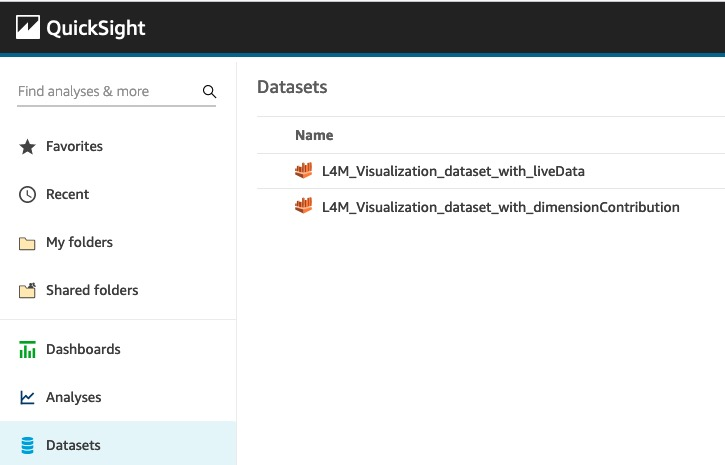

Step 2: Click on create analysis

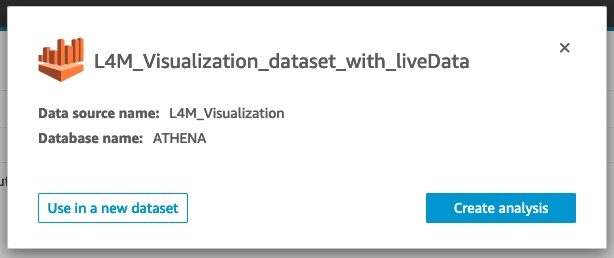

Step 3: Click on the pencil (top right corner of the image below)

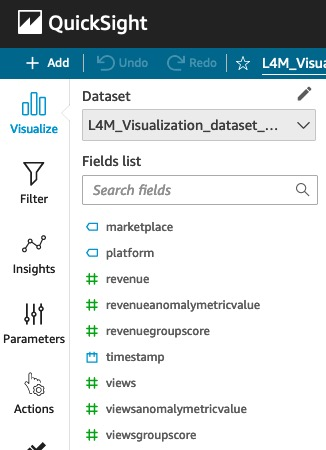

Step 4: Click on add dateset

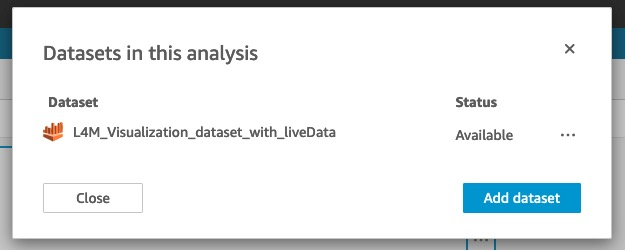

Step 5: Select the dataset and click on select

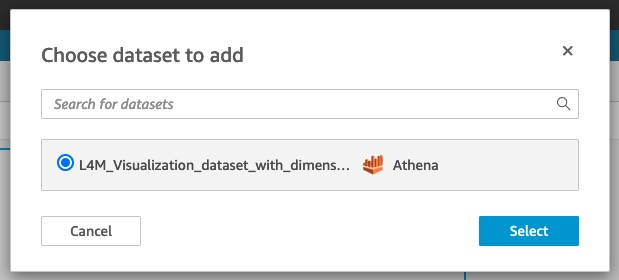

## Conclusion
You have successfully created a QuickSight analysis from L4M inference results and the live data. Two datasets are in QuickSight for you to use:
The *L4M_Visualization_dataset_with_liveData* dataset and the  *L4M_Visualization_dataset_with_dimensionContribution* dataset. 
The *L4M_Visualization_dataset_with_liveData* dataset includes the following metrics:
- The *timestamp* is the date + time of the live data passed to L4M.
- The *views* is the value of the views metric.
- The *revenue* is the value of the revenue metric.
- The *platform*, *marketplace*, *revenueAnomalyMetricValue*, *viewsAnomalyMetricValue*, *revenueGroupScore* and *viewsGroupScore* are explained below. These metrics are part of the two datasets.  


The *L4M_Visualization_dataset_with_dimensionContribution* dataset includes the following metrics:
- The *timestamp* is the date + time of when the anomaly was detected.
- The *metricName* is the metric(s) you are monitoring. 
- The *dimensionName* is the dimension within the metric.
- The *dimensionValue* is the value of the dimension.
- The *valueContribution* is the percentage on how much is the dimensionValue affecting the anomaly when detected.

The following image shows these 5 metrics together. It is an example from the Anomaly dashboard of the L4M detector.
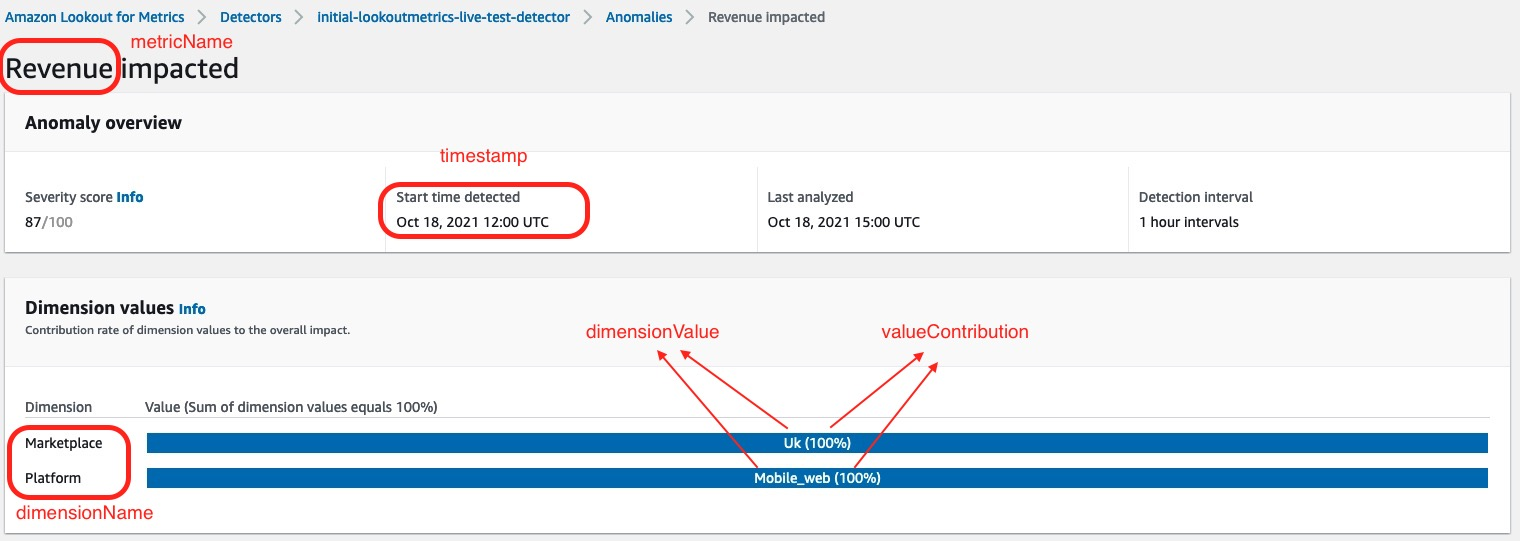

The following metrics are part of the two datasets:
- The *platform* is the platform where the anomaly happened. 
- The *marketplace* is the marketplace where the anomaly happened.
- The *revenueAnomalyMetricValue* and the *viewsAnomalyMetricValue* are the corresponding values of the metric when the anomaly was detected (in this situation, the metrics are revenue or views).
- The *revenueGroupScore* and the *viewsGroupScore* are the severity scores for each metric for the detected anomaly. 

Note: To better understand these last metrics, please go have a look on the csv files created by the Lambda function in your S3 bucket where you saved the anomalyResults/metricValue_AnomalyScore.

The next step is to build the dashboards of the data you would like to see. You swap between datasets in your analysis by clinking on the dataset box (see step 3 picture above). There are plenty of resources that teaches you how to do it. I would recommend to start with the following:

[Amazon QuickSight workshop](https://learnquicksight.workshop.aws/en/)


[Amazon QuickSight documentation](https://docs.aws.amazon.com/quicksight/latest/user/working-with-analyses.html)

Examples of visualization:

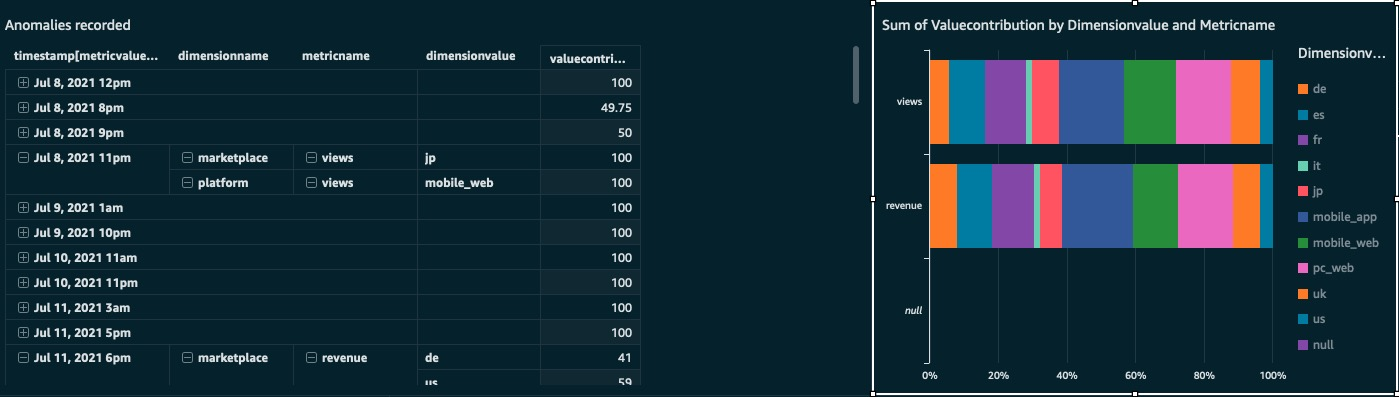

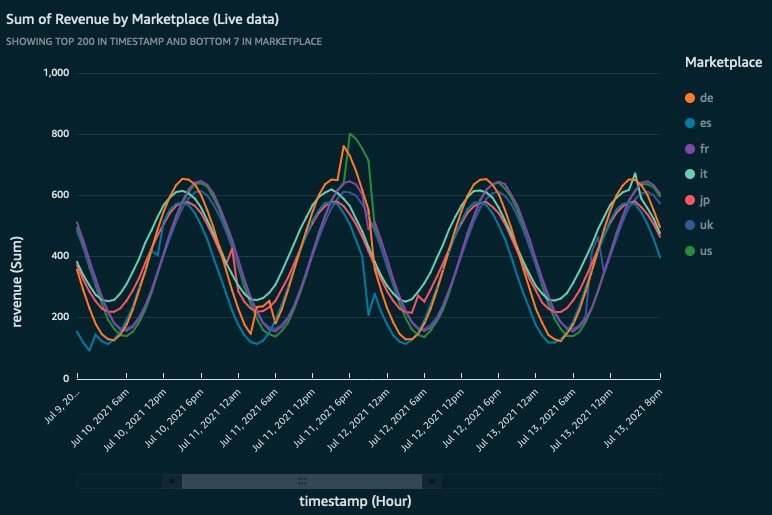

## Delete resources

In [ ]:
# Delete the Analysis
clientQuicksight.delete_analysis(
    AwsAccountId=AwsAccountId,
    AnalysisId=response_analysis['AnalysisId']
)

In [ ]:
# Delete the Dataset
clientQuicksight.delete_data_set(
    AwsAccountId=AwsAccountId,
    DataSetId=response_dataset_dimension['DataSetId']
)


In [ ]:
# Delete the Dataset
clientQuicksight.delete_data_set(
    AwsAccountId=AwsAccountId,
    DataSetId=response_dataset_live['DataSetId']
)

In [ ]:
# Delete the Datasource
response = clientQuicksight.delete_data_source(
    AwsAccountId=AwsAccountId,
    DataSourceId=response_datasource['DataSourceId']
)

In [ ]:
# Delete the crawler
clientGlue.delete_crawler(
    Name=crawler_name
)

In [ ]:
# Delete the Database from Glue
clientGlue.delete_database(
    Name=response_glueDatabase['Name']
)

In [ ]:
iam = boto3.client('iam')
# Delete the IAM role and the IAM Policy
#Crawler
iam.detach_role_policy(
    RoleName=role_name_crawler_and_Policy_ARN[0],
    PolicyArn=role_name_crawler_and_Policy_ARN[1]
)
iam.delete_role(
    RoleName=role_name_crawler_and_Policy_ARN[0]
)
iam.delete_policy(
    PolicyArn=role_name_crawler_and_Policy_ARN[1]
)

In [ ]:
#L4M Alert
iam.detach_role_policy(
    RoleName=role_L4M_name_and_ARN_and_Policy_ARN[0],
    PolicyArn=role_L4M_name_and_ARN_and_Policy_ARN[2]
)
iam.delete_role(
    RoleName=role_L4M_name_and_ARN_and_Policy_ARN[0]
)
iam.delete_policy(
    PolicyArn=role_L4M_name_and_ARN_and_Policy_ARN[2]
)

In [ ]:
#Lambda
iam.detach_role_policy(
    RoleName=role_name_lambda_and_ARN_and_Policy_ARN[0],
    PolicyArn=role_name_lambda_and_ARN_and_Policy_ARN[2]
)
iam.delete_role(
    RoleName=role_name_lambda_and_ARN_and_Policy_ARN[0]
)
iam.delete_policy(
    PolicyArn=role_name_lambda_and_ARN_and_Policy_ARN[2]
)
